In [1]:
from utils_review import *

## Meinhardt model (simplified)

Meinhardt's model from his 1982 book can we rewritten as a model with 5 variables


\begin{eqnarray}
\frac{dA}{dt}&=& \rho_0-d_A A +\frac{cA^2}{RS_A}\\
\frac{dP}{dt}&=& \rho_0-d_P P +\frac{cP^2}{RS_P}\\
\frac{dR}{dt} &=& \frac{cA^2}{S_A}+\frac{cP^2}{S_P}-\beta R\\
\frac{d S_A}{dt}  &=& \gamma_A(A-S_A)+D_A \Delta S_A \\
\frac{d S_P}{dt}  &=& \gamma_P(A-S_P)+D_P \Delta S_P \\
\end{eqnarray}

where $\Delta=\frac{\partial^2}{\partial x ^2}$ is the one D diffusion operator.
In this framework, $A$ and $P$ are activators, activating their own productions, $S_A$ and $S_P$ are diffusing repressors, and $R$ is a common repressor, activated by $A$ and $P$ so that effectively $A$ and $P$ repress each other. $A$ and $P$ encode the "anterior" and "posterior" parts of a segment (e.g. rostral or caudal parts of a somite)

Symmetry of the equations suggests a natural reduction for this system that we detail below. We take $d_A=d_P=d$, $\gamma_A=\gamma_P=\gamma$, and $D_A=D_P=D$.

We then make a quasi-equilibrium assumption on $R$ so that 

\begin{equation}
\beta R=\frac{cA^2}{S_A}+\frac{cP^2}{S_P}
\end{equation}

This gives  
\begin{equation}
\frac{d (A+P)}{dt}=2\rho_0-d(A+P)+\beta
\end{equation}
This suggests to perform a new quasi-static assumption
\begin{equation}
A+P=\frac{\beta+2\rho_0}{d}=C_0
\end{equation}

Similarly, we make a quasi-static assumption for $S_A+S_P$ so that

\begin{equation}
S_A+S_P=\frac{\beta+2\rho_0}{d}=C_0
\end{equation}
(basically, we make the system fully symmetrical in $A$, $P$)

All in all, this reduces the system to two variables, $A$ and $S$, and Meinhard's reduced model is:

\begin{eqnarray}
\frac{dA}{dt}&=& \rho_0-d A +f(A,S)\\
\frac{dS}{dt}&=&\gamma(A-S)+D \Delta S
\end{eqnarray}
wifh $f(A,S)=\beta\left (1+\frac{(C_0/A-1)^2}{C_0/S-1}\right)^{-1}$ which is the system we study and simulate below. Notice that $f$ is an increasing function of $A$ and a decreasing function of $S$, capturing the fact that $A$ is auto-activating its own expression, and $S$ repressing $A$.

In [2]:
#derivatives of the reduced Meinhardt model
def mein_derivs(vec, beta, rho, d, D):
    a = vec[0, :]
    s = vec[1, :]
    
    c0 = (beta+2*rho)/d
    
    f = beta/(1 + (c0/a - 1)**2./(c0/s - 1))   
    da = rho - d*a + f
    ds = gamma*(a-s)
    
    if len(a) > 1:
        ds += D*diffusion(s)  
    return np.array([da, ds]) #.T



def mein_derivs_1d(t, y, beta, rho, d, D):
    vec = np.reshape(y, (2, -1))   
    derivs = mein_derivs(vec, beta, rho, d, D)
    return derivs.flatten()



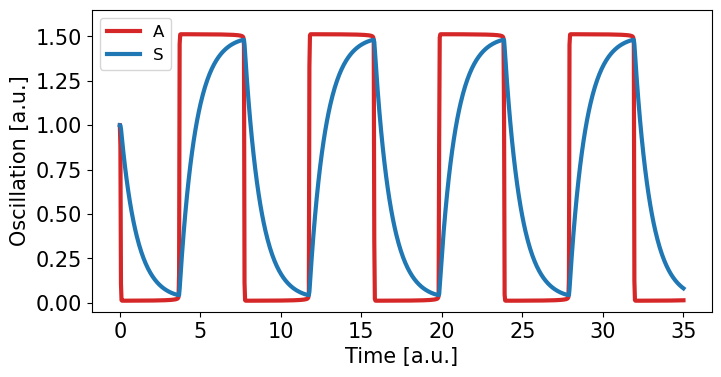

In [3]:
beta=1.5
rho=0.012
d=1
gamma=0.01
D = 0.01

t = np.linspace(0., 3500., 1000)
n_cells = 1
ap_positions = np.linspace(0.0, 1.0, n_cells)
init_vec = np.ones(n_cells*2)

names_plot = ['A', 'S']
colors_plot = ['tab:red', 'tab:blue']

results_osc = integrate(mein_derivs_1d, (np.min(t), np.max(t)), init_vec, method='RK45', t_eval=t, args=(beta, rho, d, D), rtol=1e-5).y
plt.figure(figsize = (8,4))
for i in range(2):
    plt.plot(t/100, results_osc[i], c = colors_plot[i], label = names_plot[i])
plt.legend()
plt.ylim([-0.05, 1.65])
plt.xlabel('Time [a.u.]')
plt.ylabel('Oscillation [a.u.]')
plt.show()

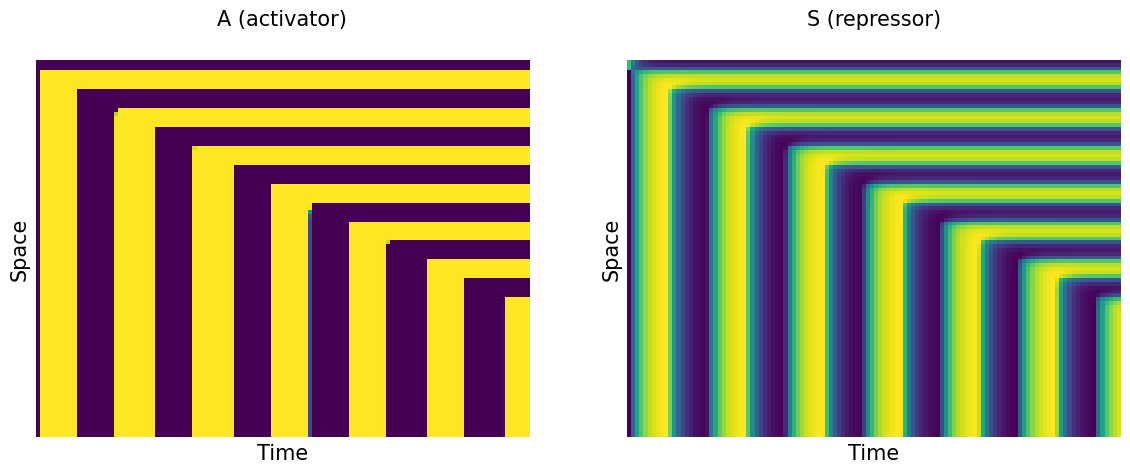

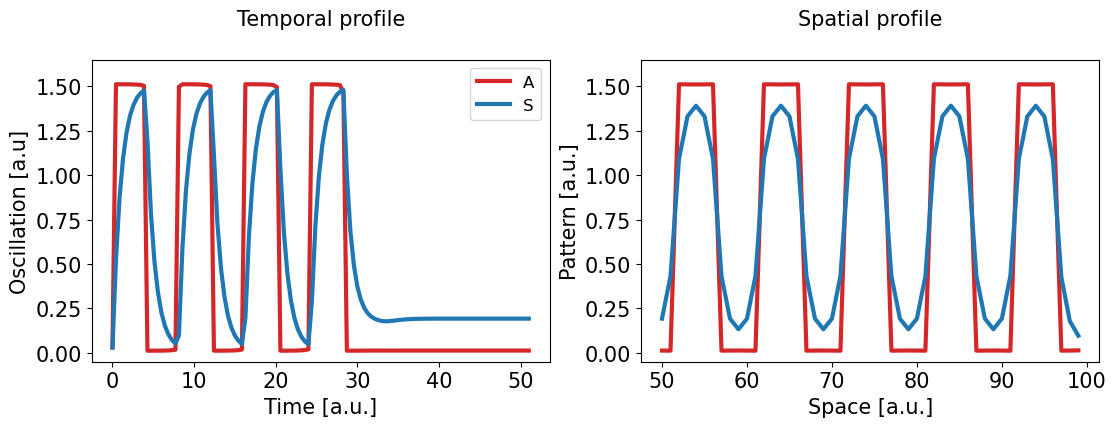

In [4]:
t = np.linspace(0., 5100., 120)
n_cells = 100

init_vec = 0.03*np.ones((2, n_cells))  #####
#we induce boundary in first 3 cells
for i in range(1,4):
    init_vec[1, -i] = 1.0

results = integrate(mein_derivs_1d, (np.min(t), np.max(t)), init_vec.flatten(), method='RK45', t_eval=t, args=(beta, rho, d, D), rtol=1e-5).y
results = np.reshape(results, (2, n_cells, -1))

fig, ax = plt.subplots(1, 2, figsize = (14,5))
plot_kymo(results[0], 'A (activator)', ax[0])
plot_kymo(results[1], 'S (repressor)', ax[1])
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (13,4))
for i in range(2):
    ax[0].plot(t/100, results[i, 60], c = colors_plot[i], label = names_plot[i])
ax[0].legend()
ax[0].set_ylim([-0.05, 1.65])
ax[0].set_xlabel('Time [a.u.]')
ax[0].set_ylabel('Oscillation [a.u]')
ax[0].set_title('Temporal profile')

for i in range(2):
    ax[1].plot(np.arange(len(results[i, 50:, 110]))+50, results[i, 50:, 110], c = colors_plot[i], label = names_plot[i])
ax[1].set_ylim([-0.05, 1.65])
ax[1].set_xlabel('Space [a.u.]')
ax[1].set_ylabel('Pattern [a.u.]')
ax[1].set_title('Spatial profile')

# plt.legend()
plt.show()

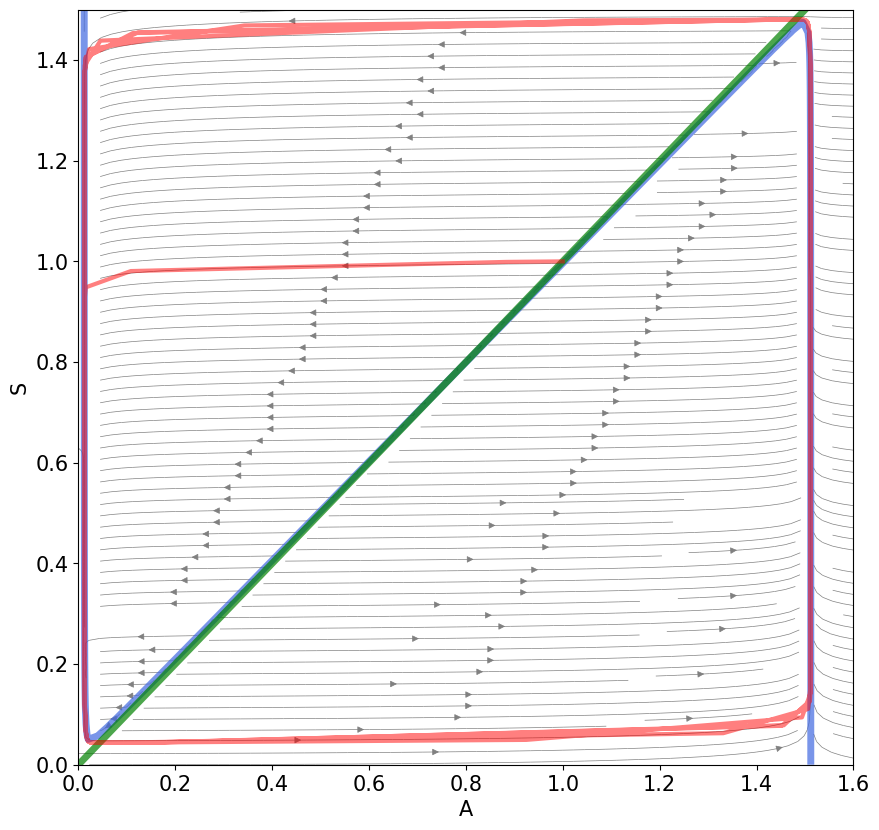

In [5]:


fig,ax=phase_plot(0,2.0,100,mein_derivs_1d, beta, rho, d, D)
npoints=100

ax.set_xlabel('A')
ax.set_ylabel('S')
ax.set_ylim([0, 1.5])
ax.set_xlim([0, 1.6])
ax.plot(results_osc[0,:],results_osc[1,:],  color='red', alpha=0.5)
plt.savefig('Meinhardt_phase_space.pdf')

## Meinhardt-Van der Pol model ( Hopf)




\begin{eqnarray}
\epsilon\frac{dA}{dt}&=& A-S+A^3/3\\
\frac{dS}{dt}&=& \lambda(A-\mu S)+ D \Delta S\\
\end{eqnarray}

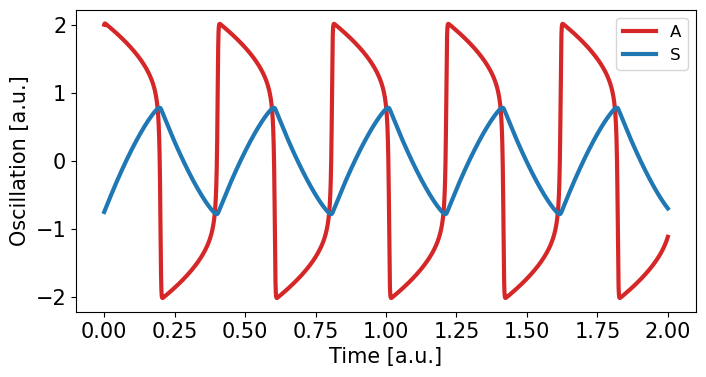

In [6]:

def vanderpol_derivs(vec,D):
    a = vec[0, :]
    s = vec[1, :]
    da=3*(-s+a-a**3./3)
    lambda_p=0.05
    bifurc=0.94*0
    ds=lambda_p*(a-0.1*s)+bifurc*lambda_p
    #Hopf at +0.094 for lambda_p=0.1 
    if len(a) > 1:
        ds += D*diffusion(s)  
    return np.array([da,ds]) #.T

def vanderpol_derivs_1d(t, y, D):
    vec = np.reshape(y, (2, -1))   
    derivs = vanderpol_derivs(vec,D)
    return derivs.flatten()   


D = 100

t = np.linspace(0., 200., 5000)
n_cells = 1
ap_positions = np.linspace(0.0, 1.0, n_cells)
init_vec = 2*np.ones(n_cells*2)
init_vec[1]=-0.75
names_plot = ['A', 'S']
colors_plot = ['tab:red', 'tab:blue']

results_osc = integrate(vanderpol_derivs_1d, (np.min(t), np.max(t)), init_vec, method='RK45', t_eval=t, args=( D, ), rtol=1e-5).y
plt.figure(figsize = (8,4))
for i in range(2):
    plt.plot(t/100, results_osc[i], c = colors_plot[i], label = names_plot[i])
plt.legend()
#plt.ylim([-4, 4])
plt.xlabel('Time [a.u.]')
plt.ylabel('Oscillation [a.u.]')
plt.show()



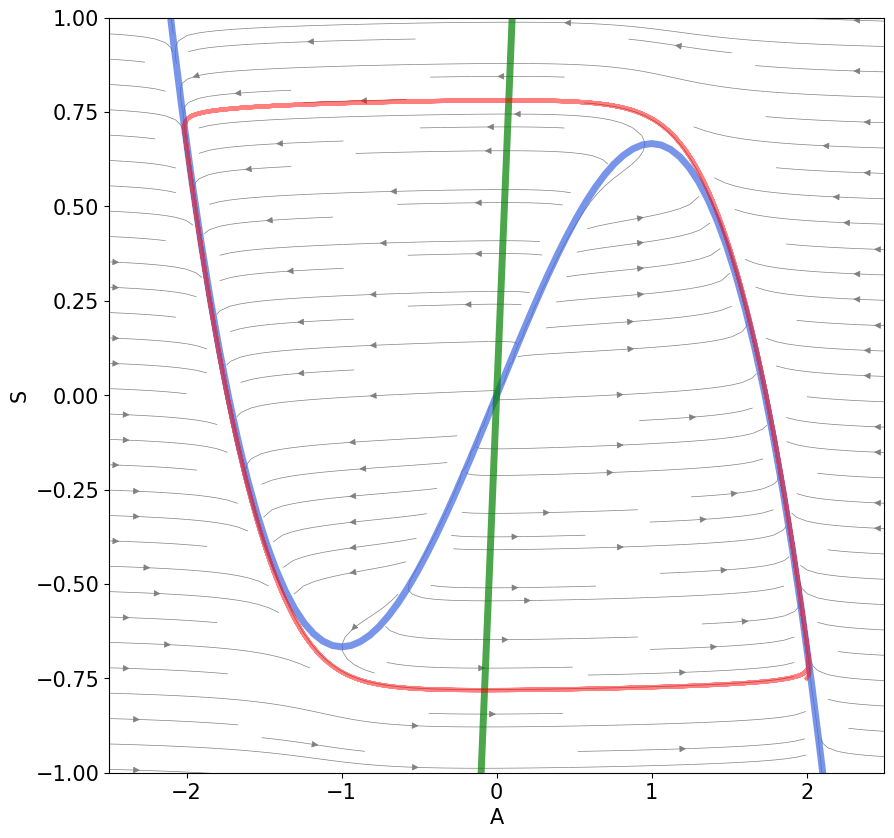

In [7]:
L=3
npoints=100

fig,ax=phase_plot(-L,L,npoints,vanderpol_derivs_1d,D)



ax.set_xlabel('A')
ax.set_ylabel('S')
ax.set_ylim([-1, 1])
ax.set_xlim([-2.5, 2.5])
ax.plot(results_osc[0,:],results_osc[1,:],  color='red', alpha=0.5)


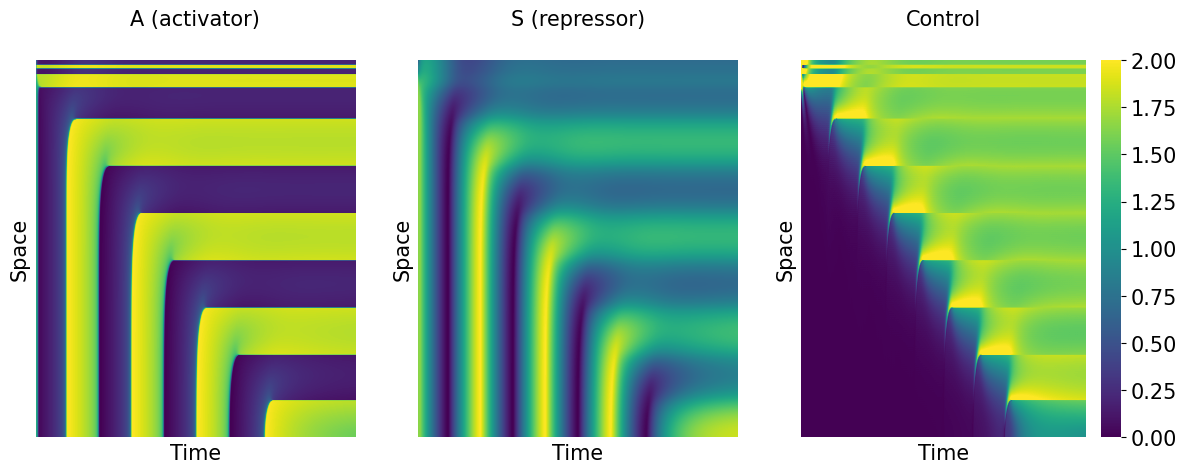

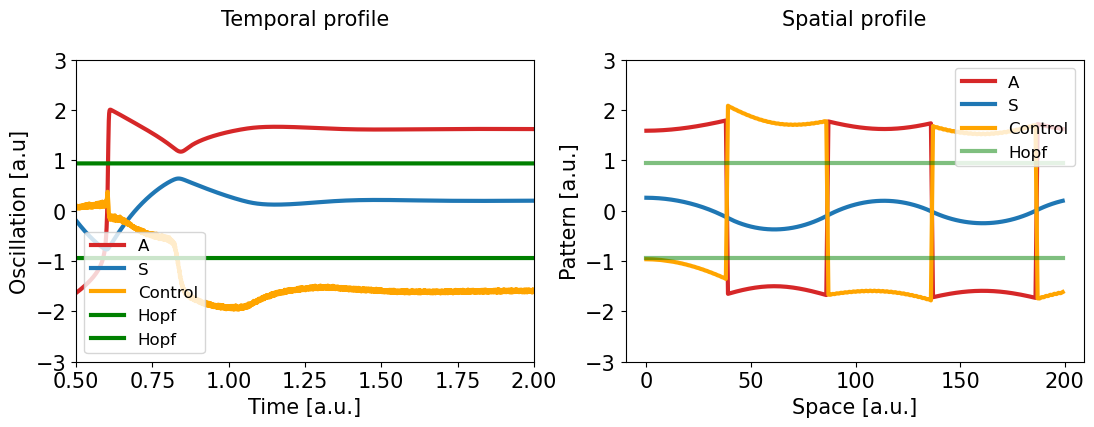

In [8]:
nstep=5000
t = np.linspace(0., 200., nstep)
n_cells = 400
lambda_p=0.05
bifurcation=0.94*lambda_p
init_vec = 0.5* np.ones((2, n_cells))  #####
#we induce boundary in first 3 cells
for i in range(1,7):
    init_vec[0, -i] = -0.5
    init_vec[1, -i] = -0.5
    init_vec[0, -i-10] = -0.5
    init_vec[1, -i-10] = -0.5

results = integrate(vanderpol_derivs_1d, (np.min(t), np.max(t)), init_vec.flatten(), method='RK45', t_eval=t, args=( D, ), rtol=1e-5).y
results = np.reshape(results, (2, n_cells, -1))


oscillation=np.zeros((n_cells,nstep))   
#print(oscillation)
for i in range(len(t)):
    variation=results[1,:,i]
    oscillation[:,i]=D*diffusion(variation)

fig, ax = plt.subplots(1, 3, figsize = (14,5))
plot_kymo(results[0], 'A (activator)', ax[0])
plot_kymo(results[1], 'S (repressor)', ax[1])
plot_kymo(np.abs(oscillation)/lambda_p,  'Control', ax[2],colorbar=True, vmin=0.0,vmax=2.0)
plt.savefig('Meinhardt_VDP_kymos.pdf')
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (13,4))
n_cell_ref=int(n_cells/2)
dummy=np.ones((nstep,1))
for i in range(2):
    ax[0].plot(t/100, results[i,n_cell_ref], c = colors_plot[i], label = names_plot[i])
ax[0].plot(t/100, oscillation[n_cell_ref,:]/lambda_p, c='orange',label = 'Control')
ax[0].plot(t/100, 0.94*dummy, c='green',label = 'Hopf')
ax[0].plot(t/100, -0.94*dummy, c='green',label = 'Hopf')
ax[0].legend()
ax[0].set_ylim([-3, 3])
ax[0].set_xlim([0.5, 2.0])
ax[0].set_xlabel('Time [a.u.]')
ax[0].set_ylabel('Oscillation [a.u]')
ax[0].set_title('Temporal profile')


time=4000
dummy=np.ones((int(n_cells/2),1))
for i in range(2):
    ax[1].plot(np.arange(len(results[i, :int(n_cells/2), time])), results[i, :int(n_cells/2), time], c = colors_plot[i], label = names_plot[i])
#ax[1].plot(np.arange(len(results[1, :int(n_cells/2), time])), results[1, :int(n_cells/2), time]*8, c = colors_plot[1], label = names_plot[1])
ax[1].plot(np.arange(len(results[i, :int(n_cells/2), time])), oscillation[:int(n_cells/2),time]/lambda_p, c='orange',label = 'Control')
ax[1].plot(np.arange(len(results[i, :int(n_cells/2), time])), 0.94*dummy, c='green',label = 'Hopf', alpha=0.5)
ax[1].plot(np.arange(len(results[i, :int(n_cells/2), time])), -0.94*dummy, c='green', alpha=0.5)
ax[1].set_ylim([-3, 3])
ax[1].legend()
ax[1].set_xlabel('Space [a.u.]')
ax[1].set_ylabel('Pattern [a.u.]')
ax[1].set_title('Spatial profile')

# plt.legend()
#plt.show()
plt.savefig('Meinhardt_VDP.pdf')
plt.show()



## Meinhardt-Van der Pol model with SNIC




\begin{eqnarray}
\epsilon\frac{dA}{dt}&=& A-S+A^3/3\\
\frac{dS}{dt}&=& \lambda(A-\mu S)+ D \Delta S\\
\end{eqnarray}

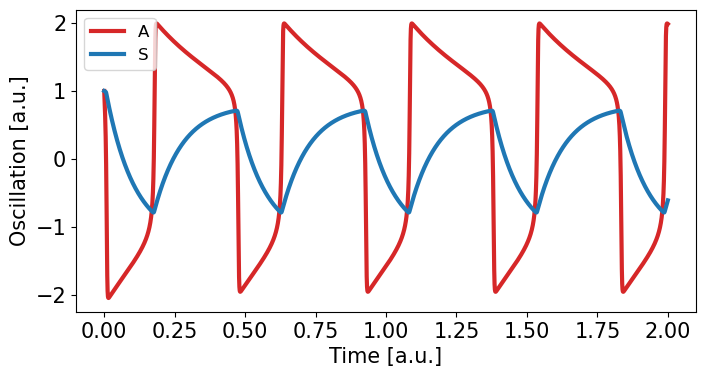

In [9]:

def vanderpol_derivs_snic(vec,D):
    a = vec[0, :]
    s = vec[1, :]
    da=3*(-s+a-a**3./3)
    ds=-0.02+0.1*np.tanh(3*a)-0.1*s
    if len(a) > 1:
        ds += D*diffusion(s)  
    return np.array([da,ds]) #.T

def vanderpol_derivs_snic_1d(t, y, D):
    vec = np.reshape(y, (2, -1))   
    derivs = vanderpol_derivs_snic(vec,D)
    return derivs.flatten()   


D = 10

t = np.linspace(0., 200., 5000)
n_cells = 1
ap_positions = np.linspace(0.0, 1.0, n_cells)
init_vec = np.ones(n_cells*2)

names_plot = ['A', 'S']
colors_plot = ['tab:red', 'tab:blue']

results_osc = integrate(vanderpol_derivs_snic_1d, (np.min(t), np.max(t)), init_vec, method='RK45', t_eval=t, args=( D, ), rtol=1e-5).y
plt.figure(figsize = (8,4))
for i in range(2):
    plt.plot(t/100, results_osc[i], c = colors_plot[i], label = names_plot[i])
plt.legend()
#plt.ylim([-4, 4])
plt.xlabel('Time [a.u.]')
plt.ylabel('Oscillation [a.u.]')
plt.show()



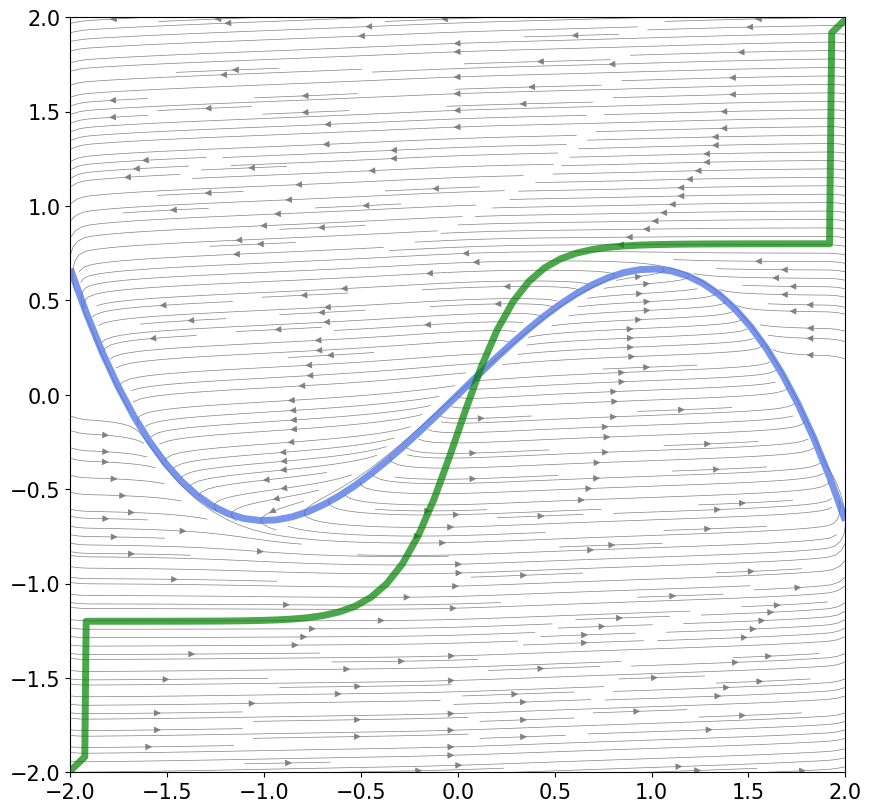

In [10]:
L=2
npoints=50

fig,ax=phase_plot(-L,L,npoints,vanderpol_derivs_snic_1d,D)



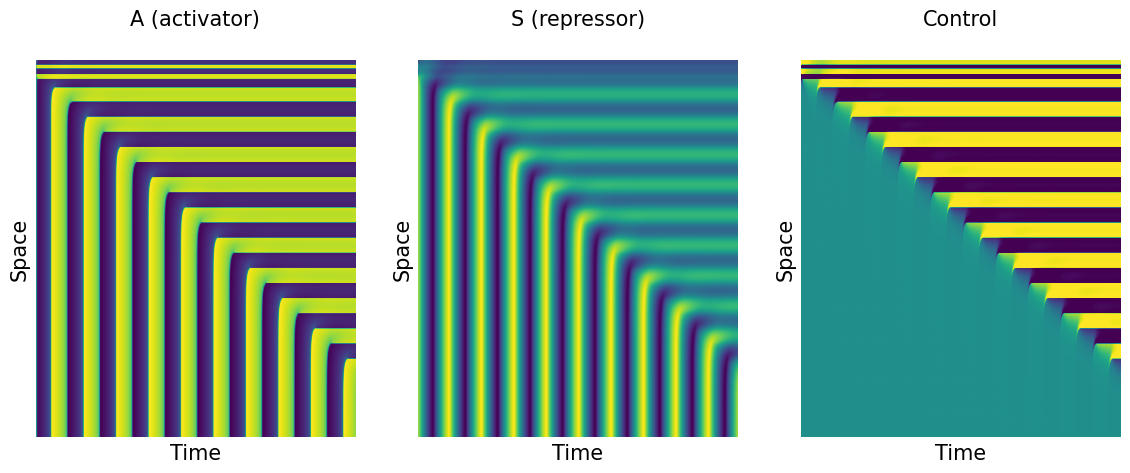

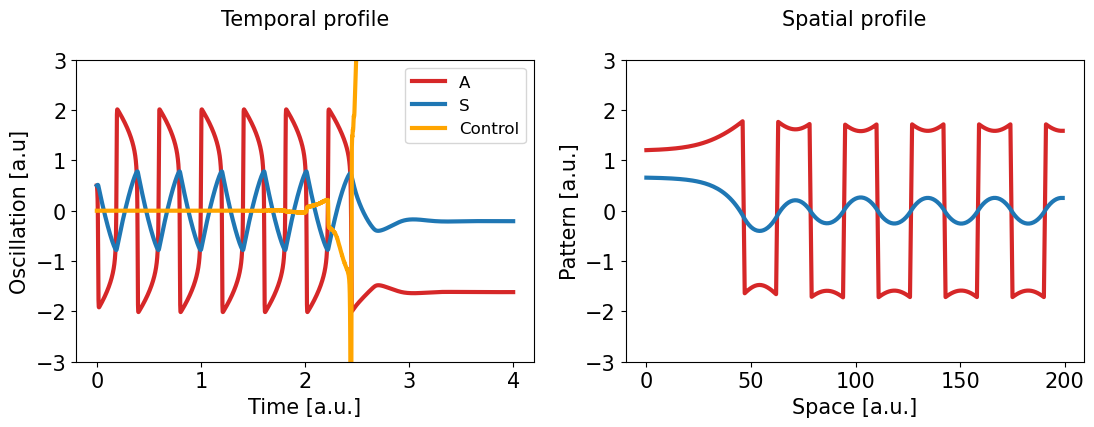

In [11]:
nstep=5000
t = np.linspace(0., 400., nstep)
n_cells = 400

init_vec = 0.5* np.ones((2, n_cells))  #####
#we induce boundary in first 3 cells
for i in range(1,7):
    init_vec[0, -i] = -0.5
    init_vec[1, -i] = -0.5
    init_vec[0, -i-10] = -0.5
    init_vec[1, -i-10] = -0.5

results = integrate(vanderpol_derivs_1d, (np.min(t), np.max(t)), init_vec.flatten(), method='RK45', t_eval=t, args=( D, ), rtol=1e-5).y
results = np.reshape(results, (2, n_cells, -1))
 
oscillation=np.zeros((n_cells,nstep))   
#print(oscillation)
for i in range(len(t)):
    variation=results[1,:,i]
    oscillation[:,i]=100*diffusion(variation)


fig, ax = plt.subplots(1, 3, figsize = (14,5))
plot_kymo(results[0], 'A (activator)', ax[0])
plot_kymo(results[1], 'S (repressor)', ax[1])
plot_kymo(oscillation, 'Control', ax[2],vmin=-0.8,vmax=0.8,)
plt.savefig('Meinhardt_VDP_kymos.pdf')
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (13,4))
n_cell_ref=int(n_cells/2)-10
for i in range(2):
    ax[0].plot(t/100, results[i,n_cell_ref], c = colors_plot[i], label = names_plot[i])
ax[0].plot(t/100, 10*oscillation[n_cell_ref,:], c='orange',label = 'Control')
ax[0].legend()
ax[0].set_ylim([-3, 3])
ax[0].set_xlabel('Time [a.u.]')
ax[0].set_ylabel('Oscillation [a.u]')
ax[0].set_title('Temporal profile')

for i in range(2):
    ax[1].plot(np.arange(len(results[i, 100:int(n_cells/2)+100, 4000])), results[i, 100:int(n_cells/2)+100, 4000], c = colors_plot[i], label = names_plot[i])
ax[1].set_ylim([-3, 3])
ax[1].set_xlabel('Space [a.u.]')
ax[1].set_ylabel('Pattern [a.u.]')
ax[1].set_title('Spatial profile')


plt.savefig('Meinhardt_SNIC_VDP.pdf')
plt.show()




### Type I and Type II excitability


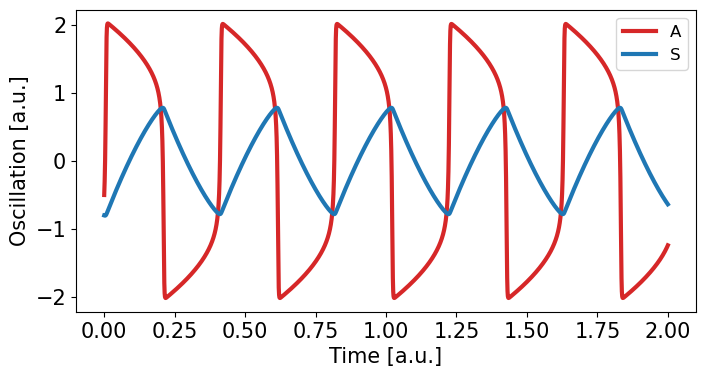

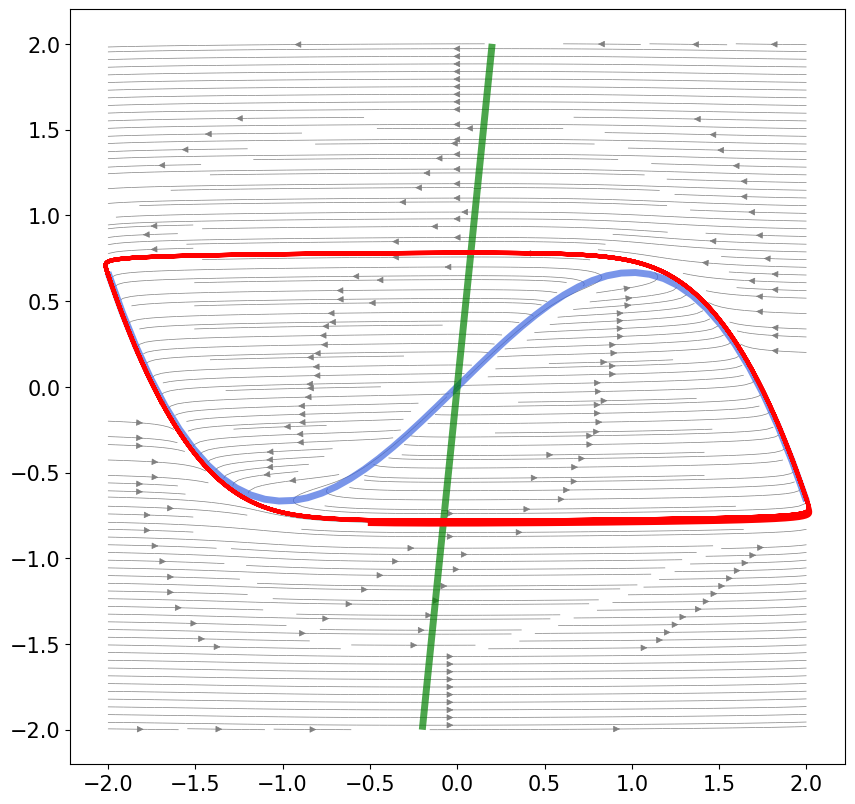

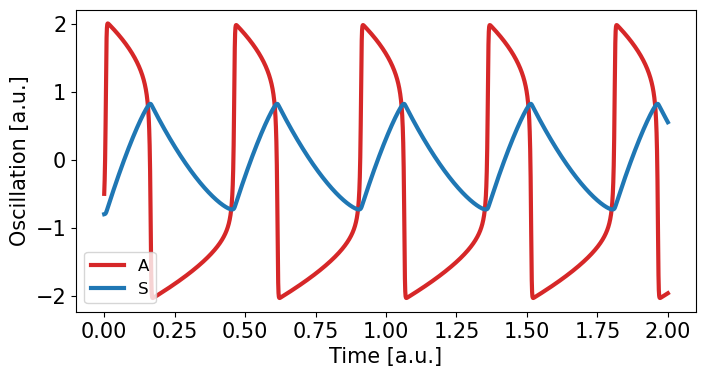

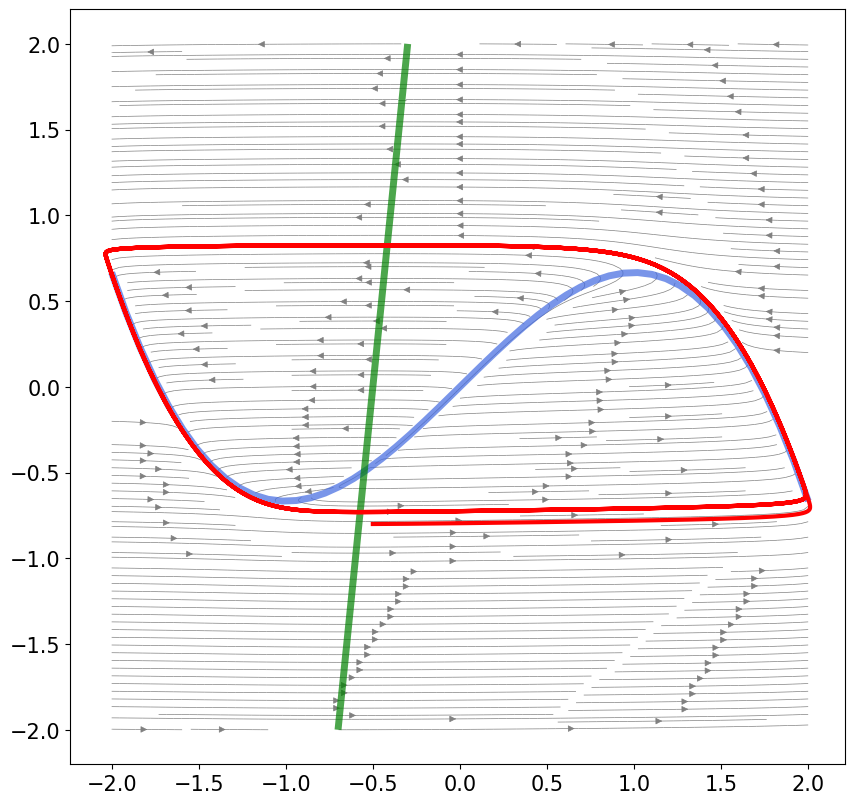

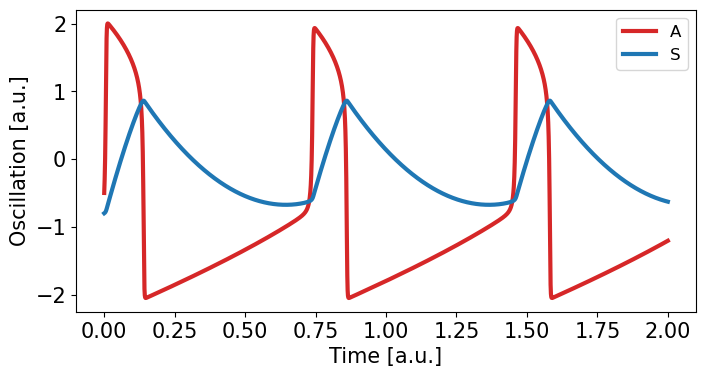

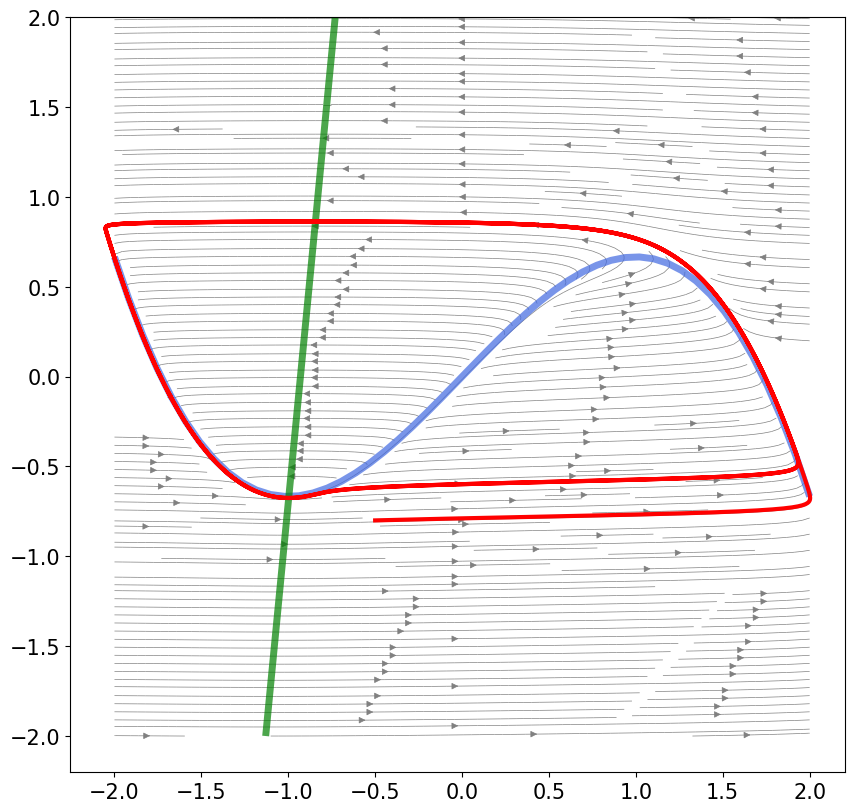

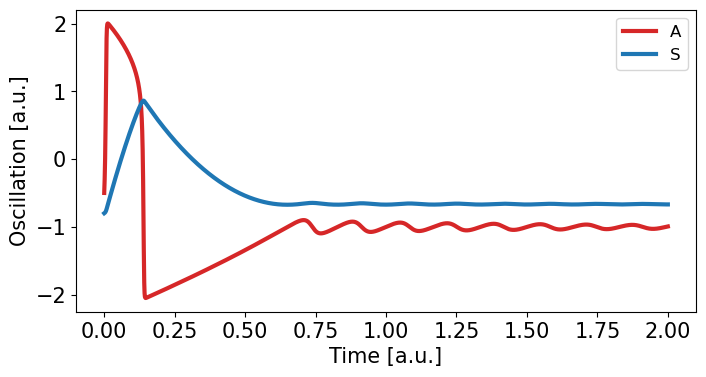

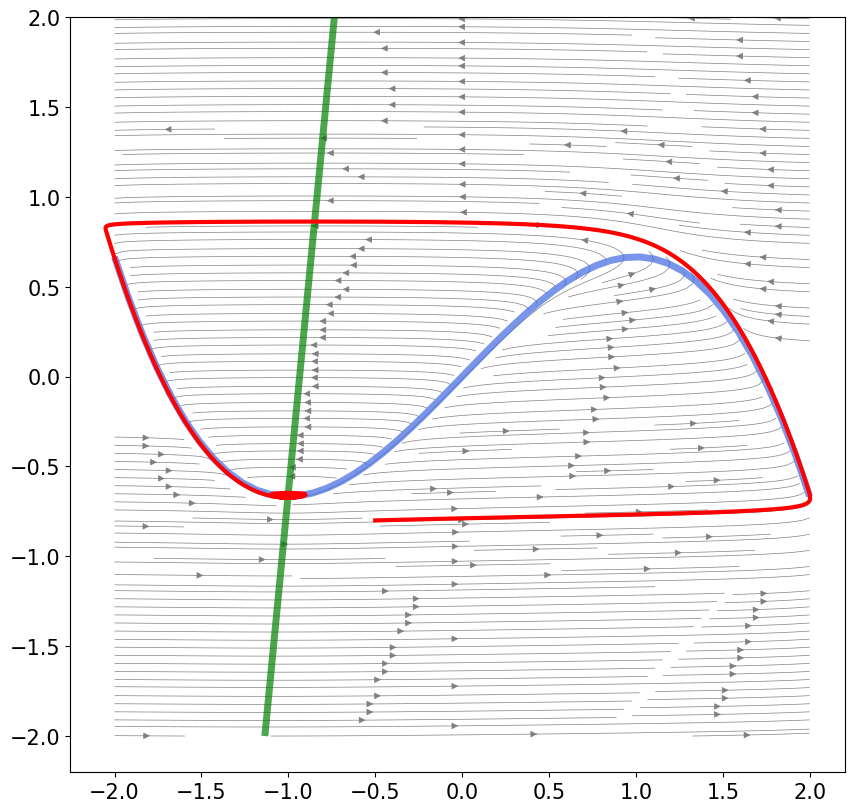

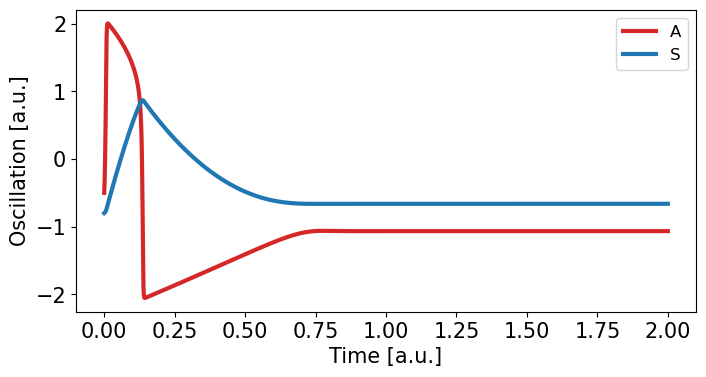

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

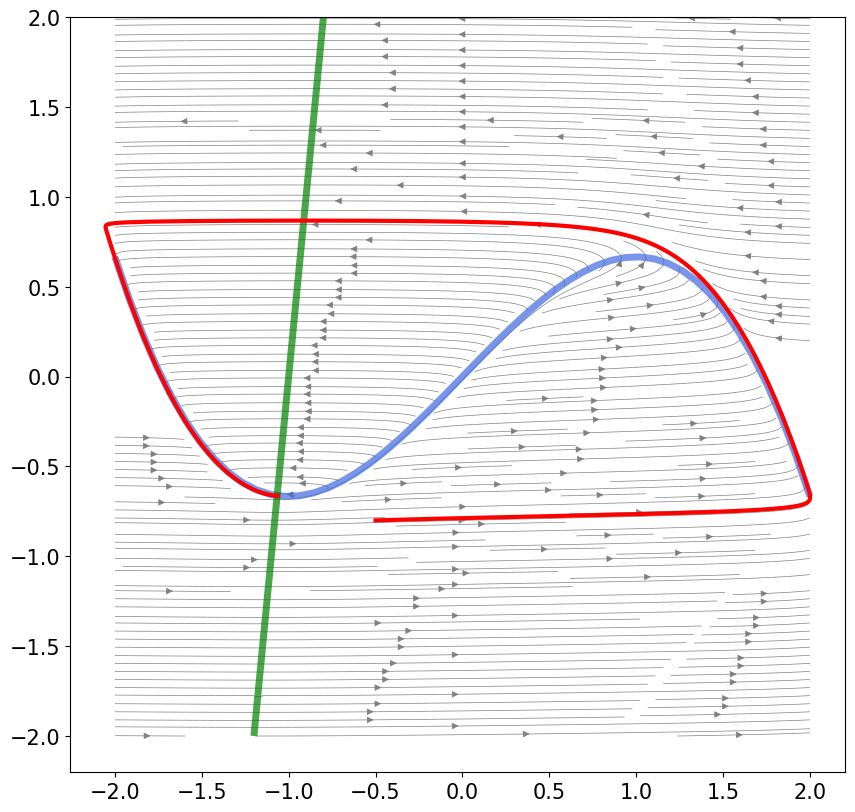

In [12]:
#Type II with Canard

def vanderpol_derivs(vec,bifurc):
    a = vec[0, :]
    s = vec[1, :]
    da=3*(-s+a-a**3./3)
    lambda_p=0.05
    ds=lambda_p*(a-0.1*s)+bifurc*lambda_p
    return np.array([da,ds]) #.T

def vanderpol_derivs_1d(t, y, h):
    vec = np.reshape(y, (2, -1))   
    derivs = vanderpol_derivs(vec,h)
    return derivs.flatten()   


#Type I


def vanderpol_derivs_snic(vec,bifurc):
    a = vec[0, :]
    s = vec[1, :]
    da=3*(-s+a-a**3./3)
    ds=bifurc+0.1*np.tanh(3*a)-0.1*s
 
    return np.array([da,ds]) #.T

def vanderpol_derivs_1d_snic(t, y, h):
    vec = np.reshape(y, (2, -1))   
    derivs = vanderpol_derivs_snic(vec,h)
    return derivs.flatten()   




    
init_vec = -0.5*np.ones(2)
init_vec[1]=-0.8
L=2
plot_excitable(vanderpol_derivs_1d,init_vec,L,0.0)  
plot_excitable(vanderpol_derivs_1d,init_vec,L,0.5) 
plot_excitable(vanderpol_derivs_1d,init_vec,L,0.93) 
plot_excitable(vanderpol_derivs_1d,init_vec,L,0.935) 
plot_excitable(vanderpol_derivs_1d,init_vec,L,1.0) 




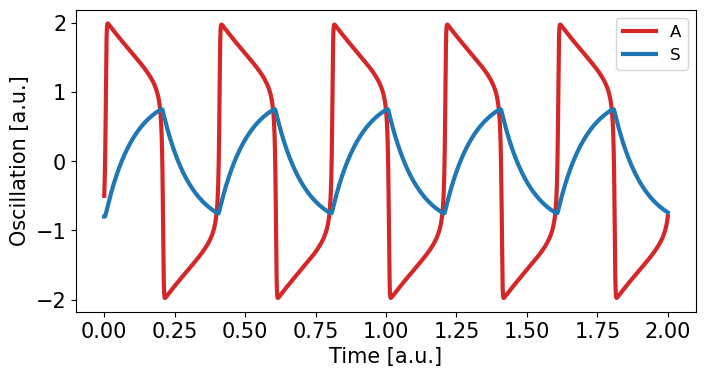

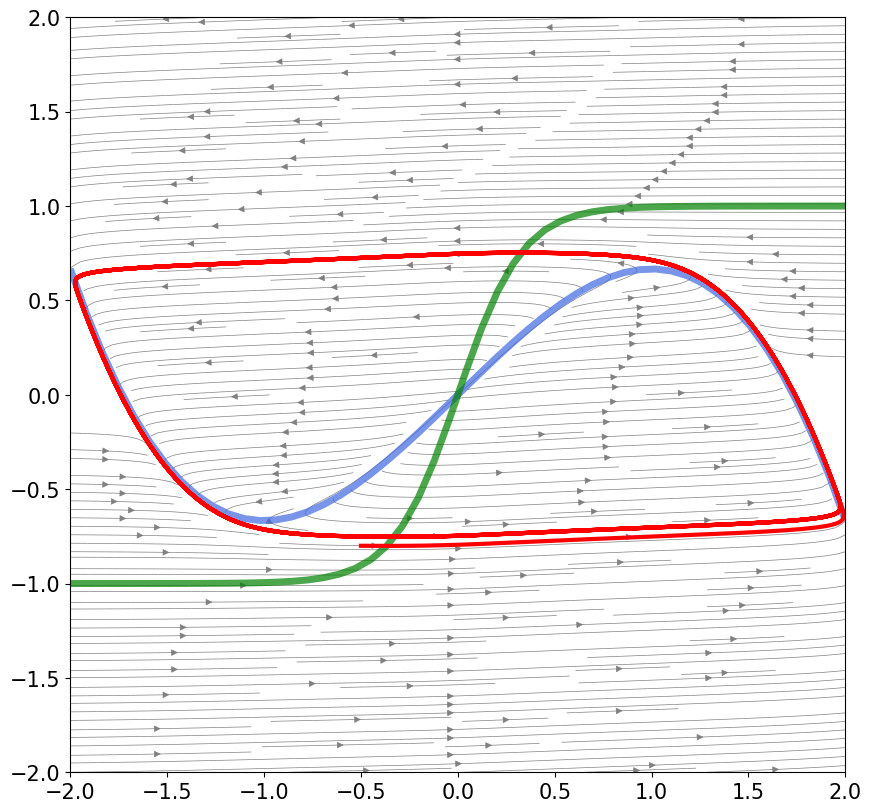

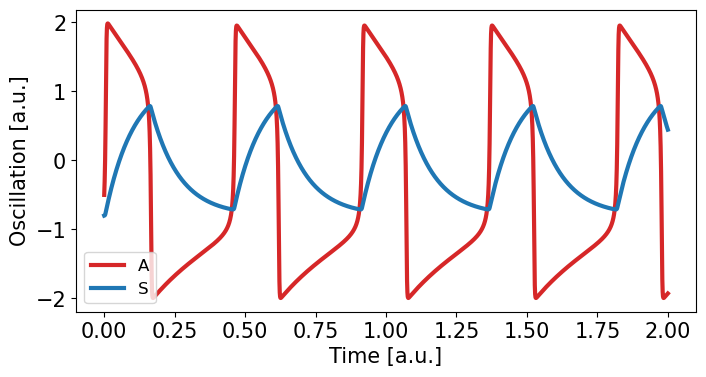

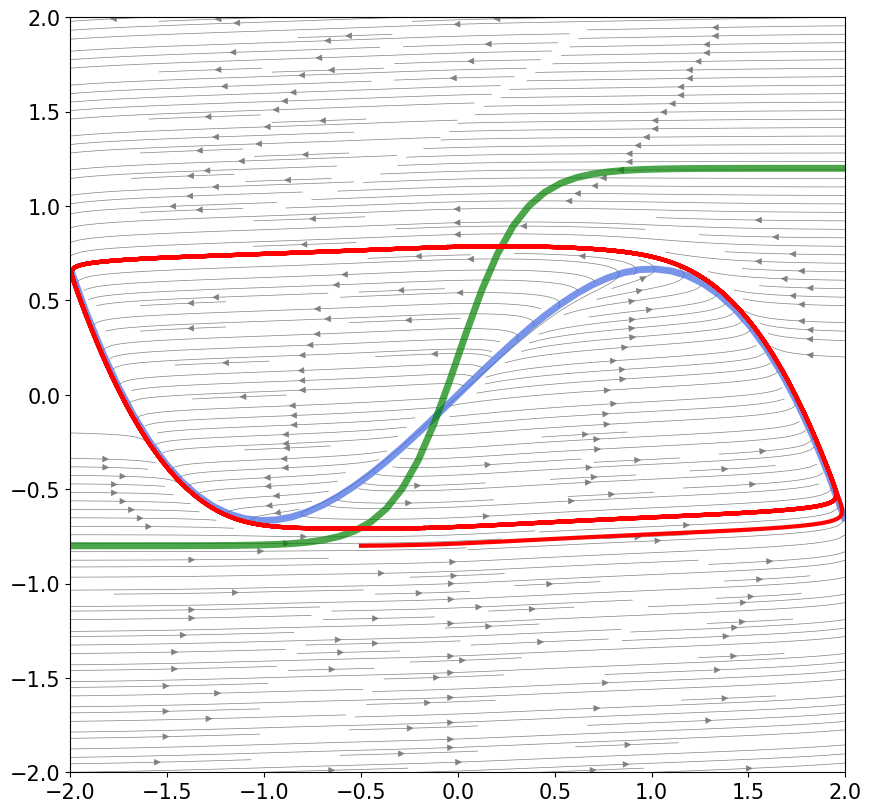

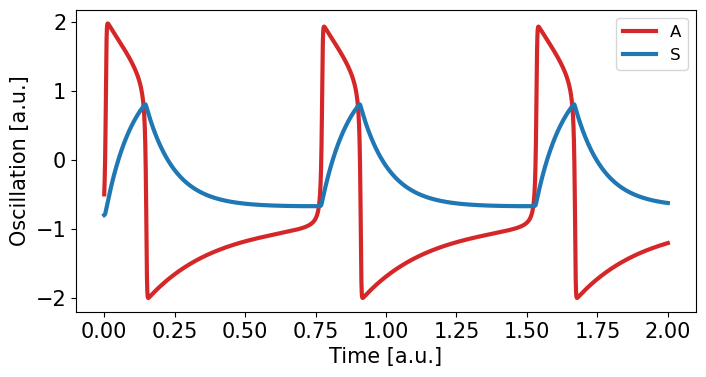

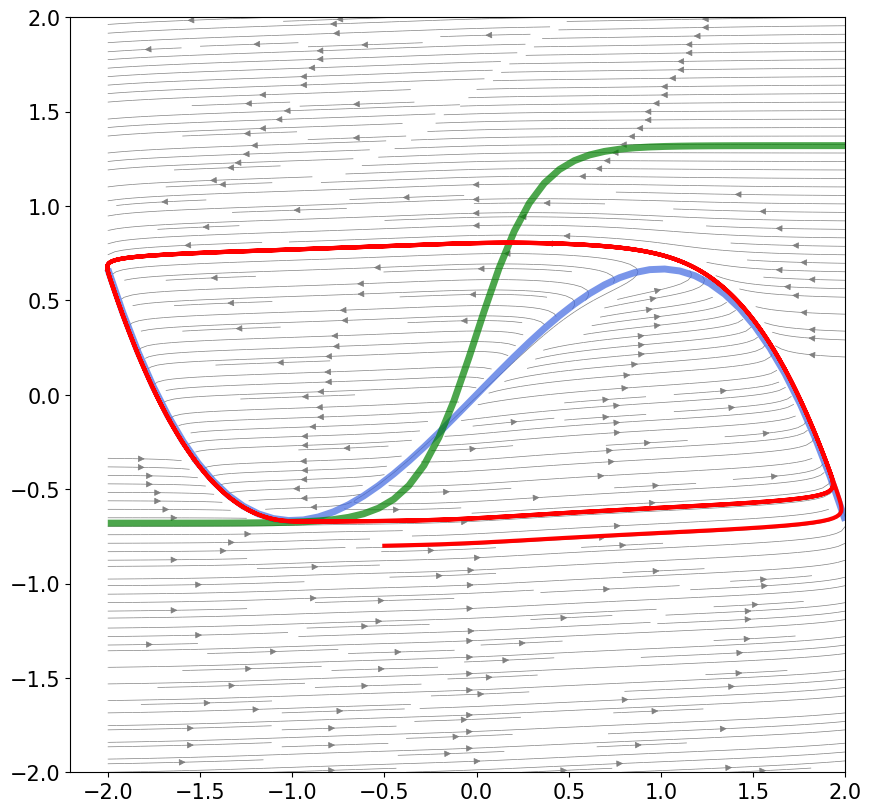

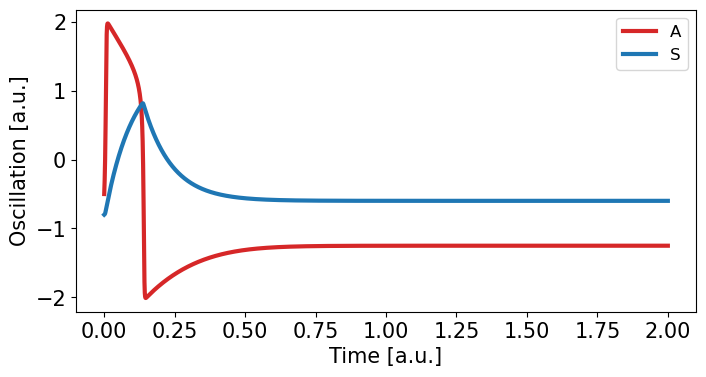

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

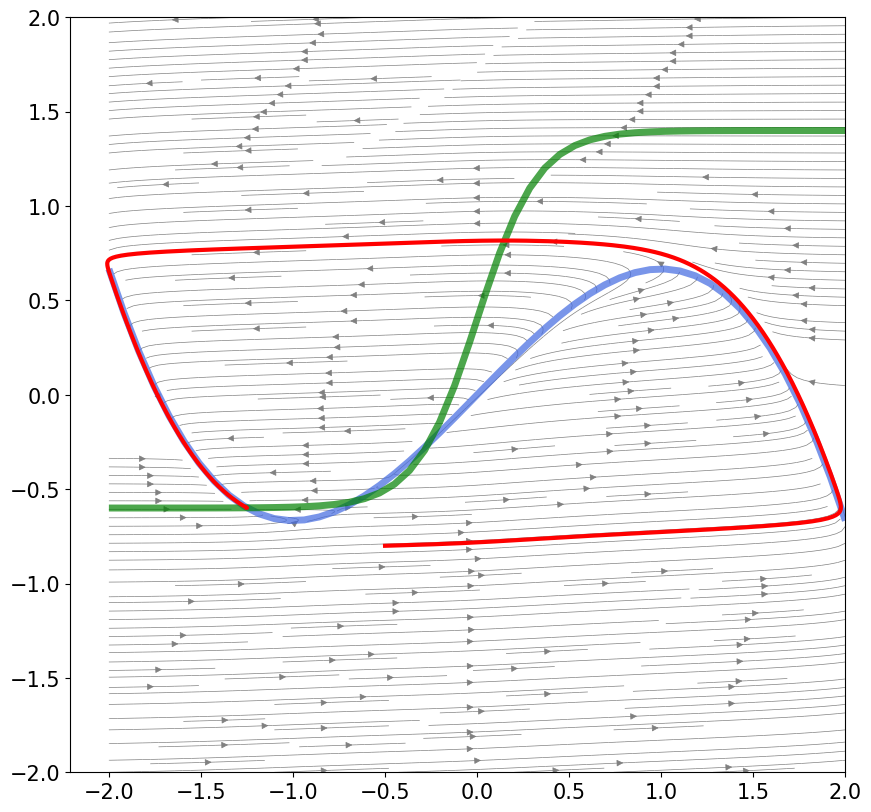

In [13]:
init_vec = -0.5*np.ones(2)
init_vec[1]=-0.8

plot_excitable(vanderpol_derivs_1d_snic,init_vec,L,+0.0)
plot_excitable(vanderpol_derivs_1d_snic,init_vec,L,+0.02)
plot_excitable(vanderpol_derivs_1d_snic,init_vec,L,+0.032)
plot_excitable(vanderpol_derivs_1d_snic,init_vec,L,+0.04)

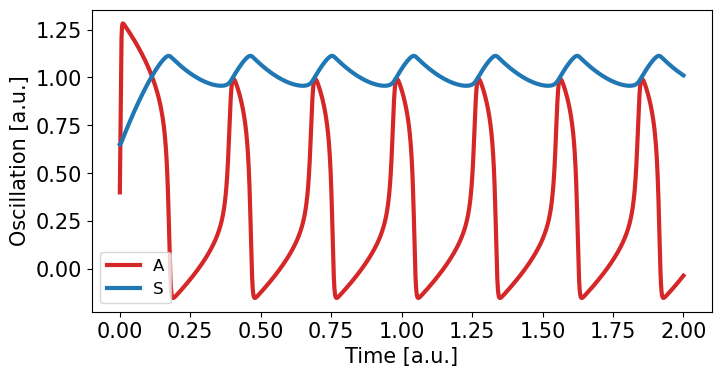

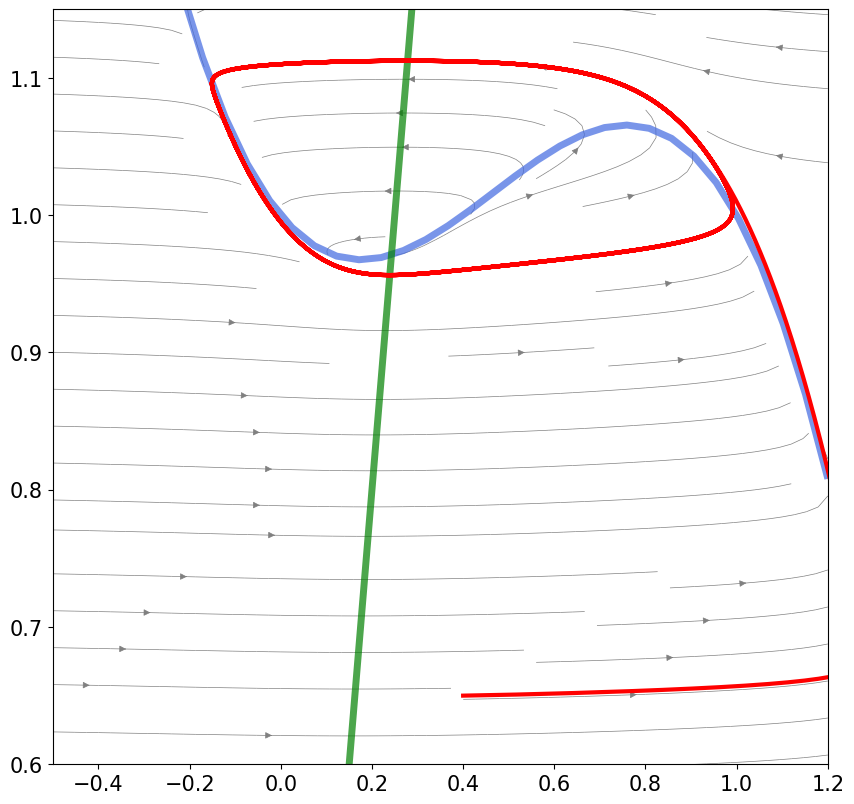

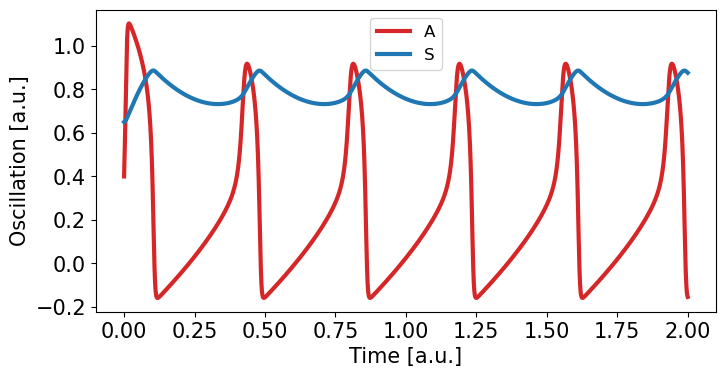

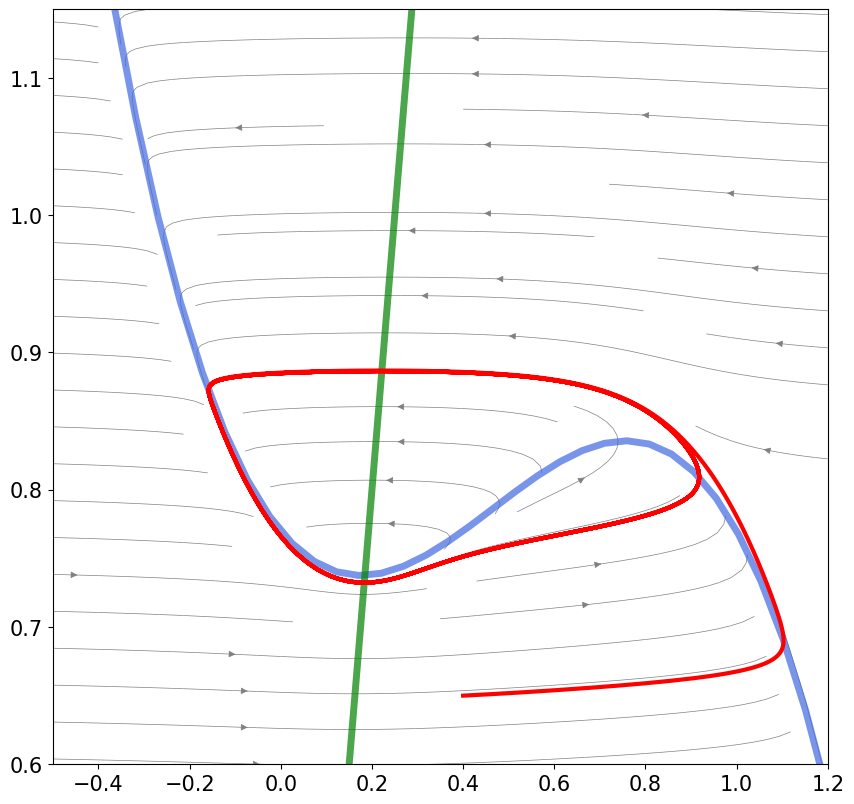

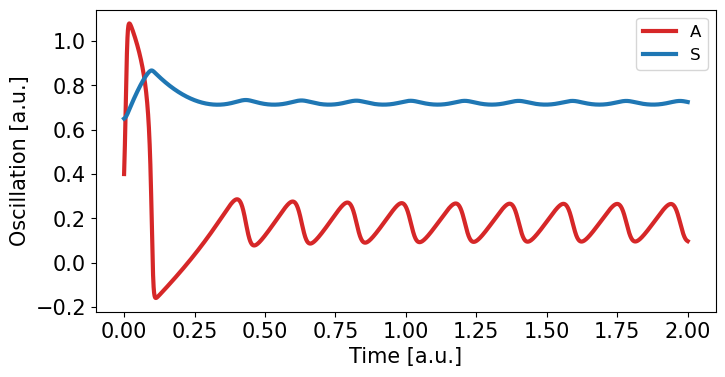

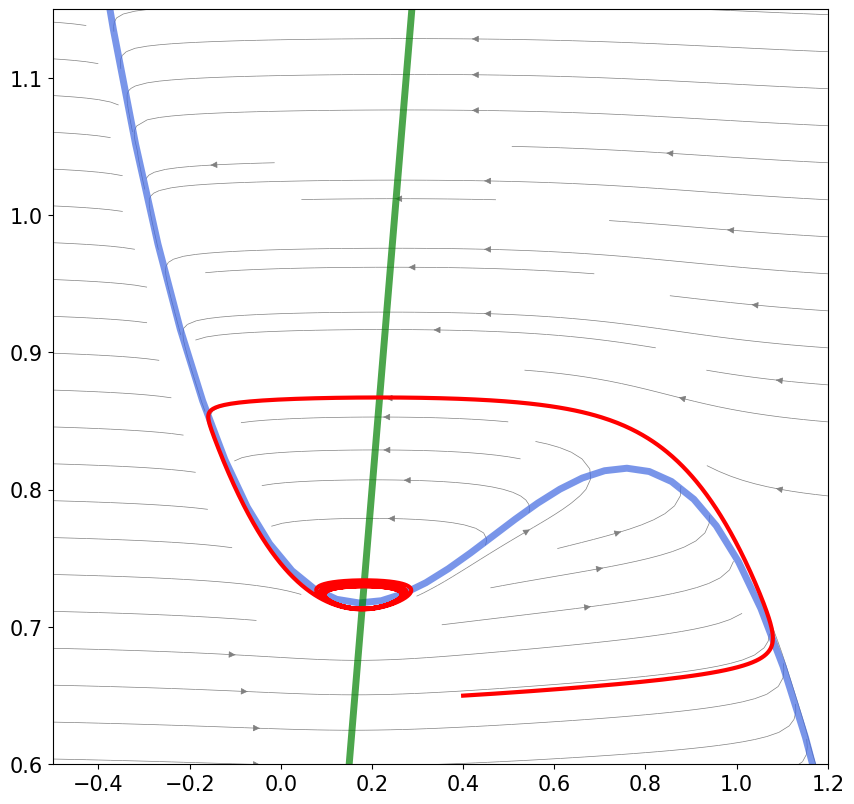

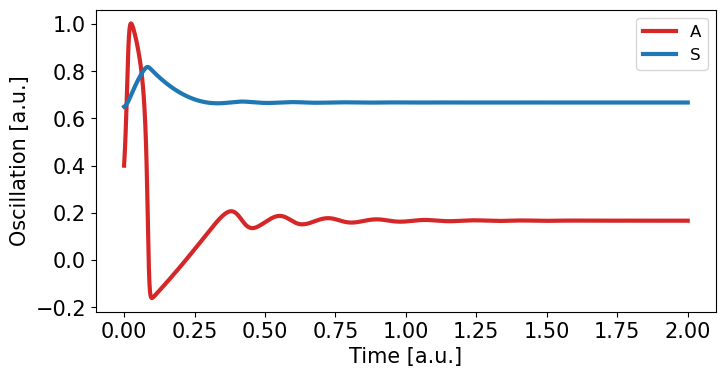

(0.6, 1.15)

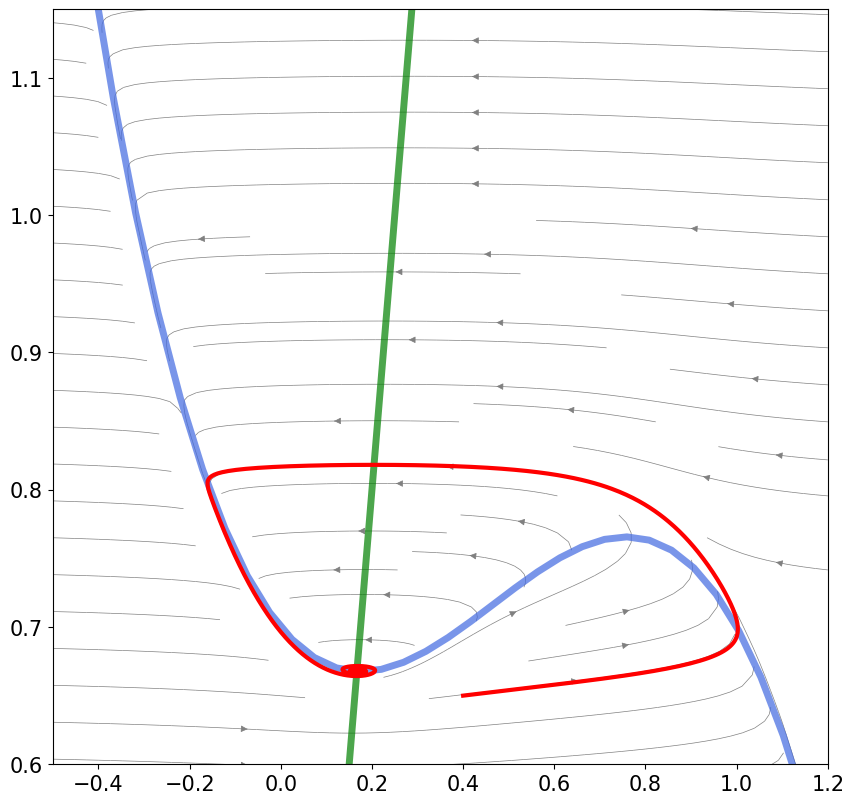

In [14]:
#Type II (model from Hubaud et al, Cell 2017)



def FitzHugh(vec,I):
    u = vec[0, :]
    v = vec[1, :]
    g=0.25
    a=0.4
    du=4*(u*(1-u)*(u-a)-v+I)
    dv=1.0/(30)*(u-g*v)
    return np.array([du,dv]) #.T

def FH_1d(t, y, h):
    vec = np.reshape(y, (2, -1))   
    derivs = FitzHugh(vec,h)
    return derivs.flatten()   

init_vec = np.zeros(2)
init_vec[0]=0.4
init_vec[1]=0.65

fig,ax=plot_excitable(FH_1d,init_vec,1.2,1.0)
ax.set_xlim([-0.5,1.2])
ax.set_ylim([0.6,1.15])

fig,ax=plot_excitable(FH_1d,init_vec,1.2,0.77)
ax.set_xlim([-0.5,1.2])
ax.set_ylim([0.6,1.15])


fig,ax=plot_excitable(FH_1d,init_vec,1.2,0.75)
ax.set_xlim([-0.5,1.2])
ax.set_ylim([0.6,1.15])

fig,ax=plot_excitable(FH_1d,init_vec,1.2,0.7)
ax.set_xlim([-0.5,1.2])
ax.set_ylim([0.6,1.15])

### PORD Model

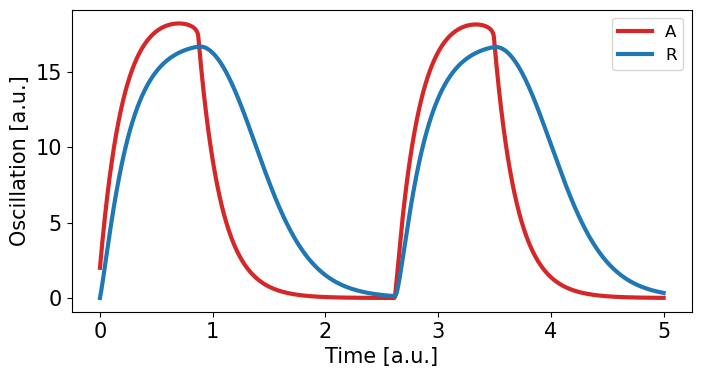

In [15]:

def phi(x):
    y=x/(x+1)
    #y=x
    y[x<0]=0
    return y


def PORD_derivs(vec,D):
    a = vec[0, :]
    s = vec[1, :]
    k1=7.68
    k2=8.04
    beta=0.5
    mu=0.05
    k3=0.31
    F=0.5
    x=k1*a-k2*s+F+beta
    #y=k1*a-k2*s+beta
    da=phi(x)-mu*a
    ds=k3*a/(1.0+k3*a)-mu*s
    if len(a) > 1:
        ds += D*diffusion(s)  
    return np.array([da,ds]) #.T

def PORD_derivs_1d(t, y, D):
    vec = np.reshape(y, (2, -1))   
    derivs = PORD_derivs(vec,D)
    return derivs.flatten()   


D = 10

t = np.linspace(0., 500, 5000)
n_cells = 1
ap_positions = np.linspace(0.0, 1.0, n_cells)
init_vec = 2*np.ones(n_cells*2)
init_vec[1]=0
names_plot = ['A', 'R']
colors_plot = ['tab:red', 'tab:blue']

results_osc = integrate(PORD_derivs_1d, (np.min(t), np.max(t)), init_vec, method='RK45', t_eval=t, args=( D, ), rtol=1e-5).y
plt.figure(figsize = (8,4))
for i in range(2):
    plt.plot(t/100, results_osc[i], c = colors_plot[i], label = names_plot[i])
plt.legend()
#plt.ylim([-4, 4])
plt.xlabel('Time [a.u.]')
plt.ylabel('Oscillation [a.u.]')
plt.show()


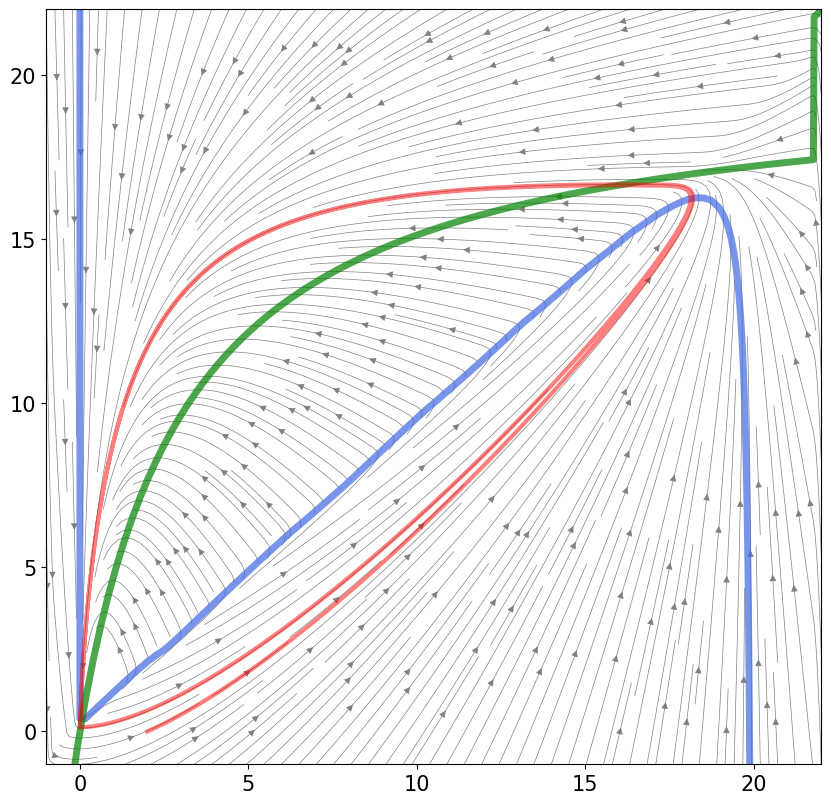

In [16]:

npoints=100

fig,ax=phase_plot(-1,22,npoints,PORD_derivs_1d,D)

ax.set_xlim([-1, 22])
ax.plot(results_osc[0,:],results_osc[1,:],  color='red', alpha=0.5)

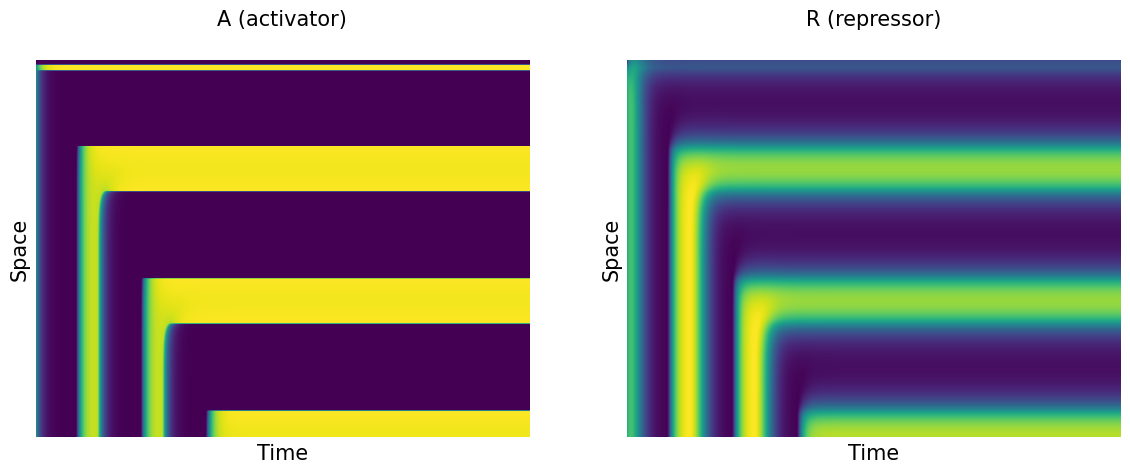

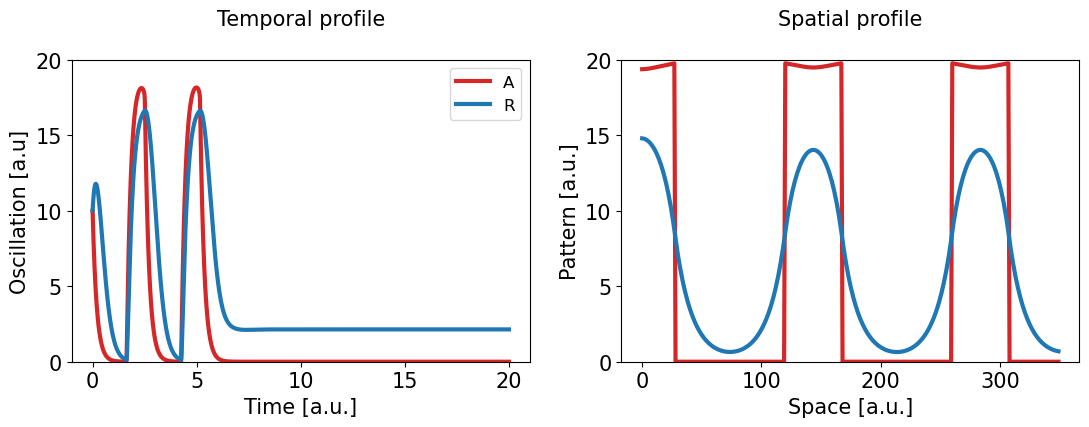

In [17]:
nstep=5000
t = np.linspace(0., 2000., nstep)
n_cells = 400

init_vec = 10* np.ones((2, n_cells))  #####
#we induce boundary in first 3 cells
for i in range(1,7):
    init_vec[0, -i] = 0.0
    init_vec[1, -i] = 0.0
    #init_vec[0, -i-10] = -0.5
    #init_vec[1, -i-10] = -0.5

results = integrate(PORD_derivs_1d, (np.min(t), np.max(t)), init_vec.flatten(), method='RK45', t_eval=t, args=( D, ), rtol=1e-5).y
results = np.reshape(results, (2, n_cells, -1))
 
#oscillation=np.zeros((n_cells,nstep))   
#print(oscillation)
for i in range(len(t)):
    variation=results[1,:,i]
    #oscillation[:,i]=100*diffusion(variation)


fig, ax = plt.subplots(1, 2, figsize = (14,5))
plot_kymo(results[0], 'A (activator)', ax[0])
plot_kymo(results[1], 'R (repressor)', ax[1])
#plot_kymo(oscillation, 'Control', ax[2],vmin=-0.8,vmax=0.8,)
plt.savefig('PORD_kymos.pdf')
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (13,4))
n_cell_ref=int(n_cells/2)-100
for i in range(2):
    ax[0].plot(t/100, results[i,n_cell_ref], c = colors_plot[i], label = names_plot[i])
#ax[0].plot(t/100, 10*oscillation[n_cell_ref,:], c='orange',label = 'Control')
ax[0].legend()
ax[0].set_ylim([0, 20])
ax[0].set_xlabel('Time [a.u.]')
ax[0].set_ylabel('Oscillation [a.u]')
ax[0].set_title('Temporal profile')

for i in range(2):
    ax[1].plot(np.arange(len(results[i, 0:int(n_cells/2)+150, 4000])), results[i, 0:int(n_cells/2)+150, 4000], c = colors_plot[i], label = names_plot[i])
ax[1].set_ylim([0, 20])
ax[1].set_xlabel('Space [a.u.]')
ax[1].set_ylabel('Pattern [a.u.]')
ax[1].set_title('Spatial profile')

# plt.legend()
#plt.show()
plt.savefig('PORD.pdf')
plt.show()

## Keener reduced model

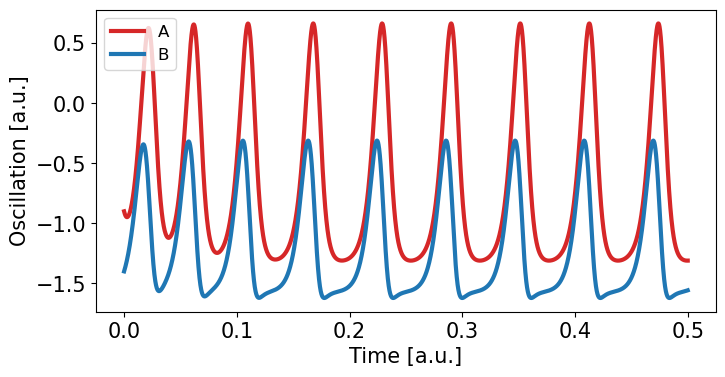

In [18]:
def keener_derivs(vec):
    a = vec[0, :]
    b = vec[1, :]
    mu=1.0
    l=-2
    c=-1
    d=1
    
    #homoclinic at 1.55, Hopf at 0 
    #da=-mu*a+b+epsilon*(0.5-a)*(0.5-a)
    # Hopf around epsilon=0.3, homoclinic aroung epsilon=0.01125
    #da=-mu*a+b+epsilon*(2*a*a+10+8*b)
    epsilon=0.1
    #epsilon=0
    #mu=0
    mu=1
    #Hopf around epsilon=0.5
    epsilon=0.26
    da=-mu*a+b+epsilon*(2*a*a+10+8*b)
    db=a*(l+c*a)+1.2*mu*b+d
    return np.array([da,db]) #.T

def keener_derivs_1d(t, y):
    vec = np.reshape(y, (2, -1))   
    derivs = keener_derivs(vec)
    return derivs.flatten()   



t = np.linspace(0.,50., 5000)
n_cells = 1
init_vec = -1.2*np.ones(n_cells*2)
#init_vec[0]=-1.0*0
init_vec[0]=-0.9
init_vec[1]=-1.4
names_plot = ['A', 'B']
colors_plot = ['tab:red', 'tab:blue']

results_osc = integrate(keener_derivs_1d, (np.min(t), np.max(t)), init_vec, method='RK45', t_eval=t, rtol=1e-6).y
plt.figure(figsize = (8,4))
for i in range(2):
    plt.plot(t/100, results_osc[i], c = colors_plot[i], label = names_plot[i])
plt.legend()
#plt.ylim([-4, 4])
plt.xlabel('Time [a.u.]')
plt.ylabel('Oscillation [a.u.]')
#plt.show()

plt.savefig('Oscillation_Keener.png')

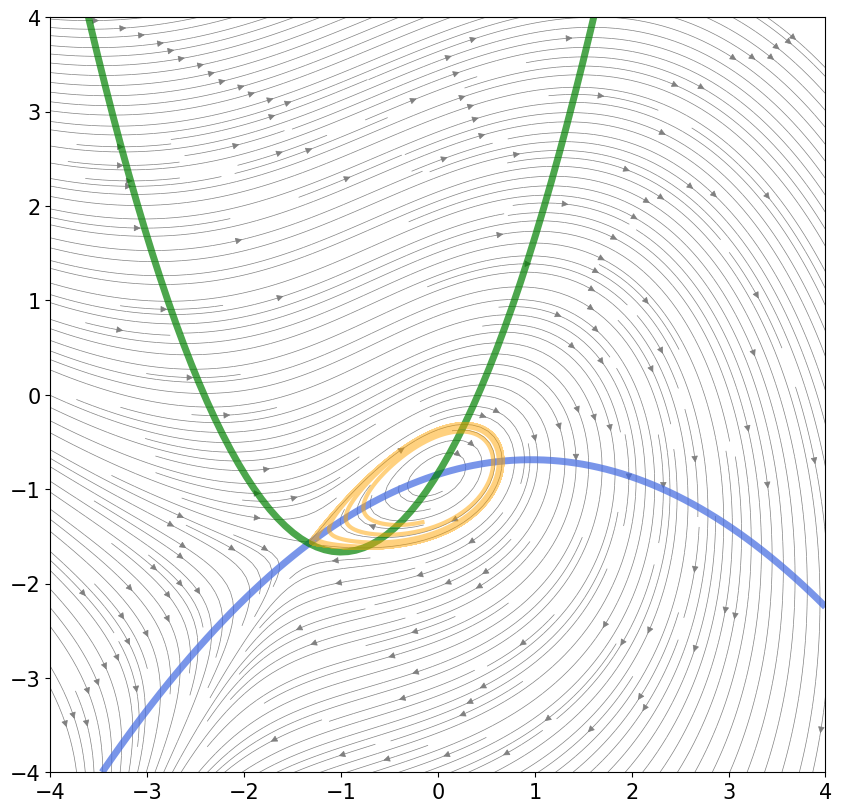

In [19]:
npoints=100
L=4

fig,ax=phase_plot(-L,L,npoints,keener_derivs_1d,)


init_vec = -np.ones(n_cells*2)
init_vec[0]=-0.16
init_vec[1]=-1.35
results_osc = integrate(keener_derivs_1d, (np.min(t), np.max(t)), init_vec, method='RK45', t_eval=t, rtol=1e-6).y

ax.plot(results_osc[0,:],results_osc[1,:],  color='orange', alpha=0.5)


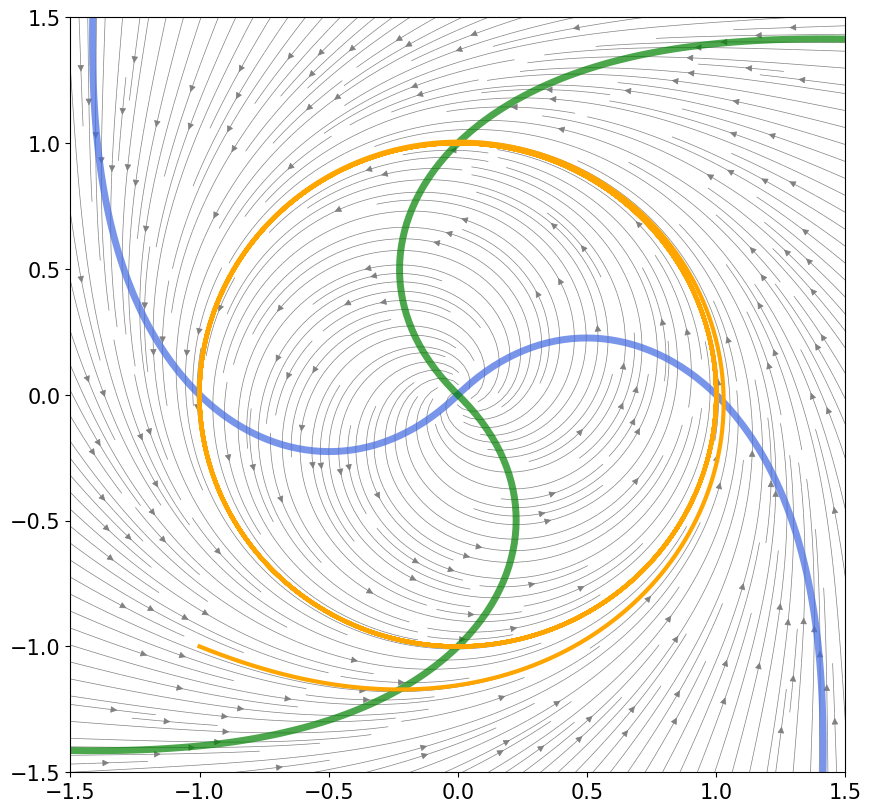

In [20]:
def limit_cycle_derivs(vec):
    a = vec[0, :]
    b = vec[1, :]
    r = np.sqrt(a*a+b*b)
    da=-b+a*(1-r)
    db=a+b*(1-r)
    return np.array([da,db]) #.T

def limit_cycle_derivs_1d(t, y):
    vec = np.reshape(y, (2, -1))   
    derivs = limit_cycle_derivs(vec)
    return derivs.flatten() 

L=1.5
fig,ax=phase_plot(-L,L,npoints,limit_cycle_derivs_1d,)


init_vec = -np.ones(n_cells*2)

results_osc = integrate(limit_cycle_derivs_1d, (np.min(t), np.max(t)), init_vec, method='RK45', t_eval=t, rtol=1e-6).y

ax.plot(results_osc[0,:],results_osc[1,:],  color='orange', alpha=1.0)


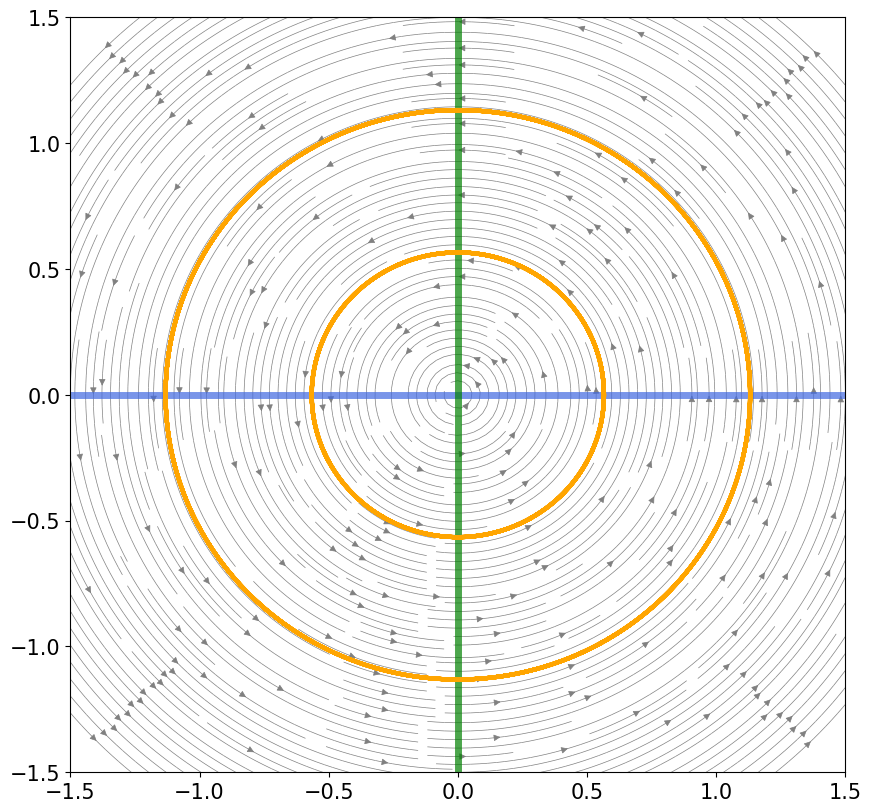

In [21]:
def harmonic_derivs(vec):
    a = vec[0, :]
    b = vec[1, :]
    da=-b
    db=a
    return np.array([da,db]) #.T

def harmonic_derivs_1d(t, y):
    vec = np.reshape(y, (2, -1))   
    derivs = harmonic_derivs(vec)
    return derivs.flatten() 

L=1.5
fig,ax=phase_plot(-L,L,npoints,harmonic_derivs_1d,)


init_vec = -0.8*np.ones(n_cells*2)

results_osc = integrate(harmonic_derivs_1d, (np.min(t), np.max(t)), init_vec, method='RK45', t_eval=t, rtol=1e-6).y

ax.plot(results_osc[0,:],results_osc[1,:],  color='orange', alpha=1.0)

init_vec = -0.4*np.ones(n_cells*2)

results_osc = integrate(harmonic_derivs_1d, (np.min(t), np.max(t)), init_vec, method='RK45', t_eval=t, rtol=1e-6).y

ax.plot(results_osc[0,:],results_osc[1,:],  color='orange', alpha=1.0)
